In [23]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import signal

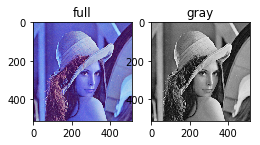

In [2]:
originImage = cv2.imread("../lena.jpg")
grayImage = cv2.cvtColor(originImage,cv2.COLOR_BGR2GRAY)
originImage32x32 = cv2.imread("../lena_32x32.jpg")
grayImage32x32 = cv2.cvtColor(originImage32x32,cv2.COLOR_BGR2GRAY)
plt.subplot(1, 3, 1)
plt.title("full")
plt.imshow(originImage)
plt.subplot(1, 3, 2)
plt.title("gray")
plt.gray()
plt.imshow(grayImage)

In [3]:
def show_img(src,desc,r,c,Iid):
    plt.subplot(r, c, Iid)
    plt.title(desc)
    plt.imshow(src)


kernel: 
[[ 1.  0.]
 [ 0. -1.]]
dst_full[0:2,0:2]:
[[  0   0]
 [  0 162]]

In [4]:
A=np.array(([[ 1.,  0.],[ 0., -1.]]),np.float32)
B=np.array(([[  0 ,  0,1], [  0 ,162,1]]),np.float32)
print(A)
print(B[0:2,0:2])
print(A*B[0:2,0:2])
print(np.sum(A*B[0:2,0:2]))

[[ 1.  0.]
 [ 0. -1.]]
[[  0.   0.]
 [  0. 162.]]
[[   0.    0.]
 [   0. -162.]]
-162.0


In [28]:
# full类型卷积操作.
#
# ax,ay: anchor's location

def conv2d_same(src,kernel,ax,ay,stride):
    kw,kh=kernel.shape
    iwo,iho=src.shape
    r=int(kw/2)
    dst=src.copy()
    dst_full=np.pad(dst,((r,r),(r,r)),constant_values=(0,0),mode='constant') # 扩充2r个0
    dst_full=dst_full.astype(np.float32)
    dest = dst_full.copy()
    i=j=r
    iw,ih=dest.shape
    #print("r:%d,iw:%d,ih:%d,pad_iw:%d,pad_ih:%d" %(r,iwo,iho,iw,ih))
    #debug_cnt=0
    if kw%2==1:
        odds=1
    else:
        odds=0
    #print("i:%d,iw:%d,ih:%d,r:%d,odds:%d" %(i,iw,ih,r,odds))
    sax=ax
    say=ay
    while i< (iw+2*r-r-odds-1):
        while j<(ih+2*r-r-odds-1):
            temp=kernel*dst_full[(i-r):(i+r+odds),(j-r):(j+r+odds)]
            '''
            if debug_cnt<10:
                print("[i:%d,j:%d]origin dest[%d,%d]:%d" %(i,j,ax,ay,dest[ax,ay]))
                print("kernel:",kernel)
                print("dst_full[%d:%d,%d:%d]:%s" %((i-r),(i+r+odds),(j-r),(j+r+odds),dst_full[(i-r):(i+r+odds),(j-r):(j+r+odds)]))
            '''
            dest[ax,ay]=np.sum(temp)
            '''
            if debug_cnt<10:
                debug_cnt+=1
                print("[i:%d,j:%d]after dest[%d,%d]:%d" %(i,j,ax,ay,dest[ax,ay]))
            '''
            j+=stride
            ay+=stride
        i+=stride
        ax+=stride
        j=r
        ay=say # 易忘记,参数的回归,迭代,更新.

    return dest

def conv1d_same(src,kernel,ax,ay,stride):
    kw,kh=kernel.shape
    if kw<=1 and kh <=1:
        print("wrong kernel size")
        return 
    if kh==1: # n行1列的kernel,在列上按行卷积
        r=int(kw/2)
        dst=src.copy()
        dst_full=np.pad(dst,((r,r),(0,0)),constant_values=(0,0),mode='constant') # 扩充2r个0
        dst_full=dst_full.astype(np.float32)
        #dest = dst_full.copy()
        dest=np.zeros(dst_full.shape,np.float32)
        iw,ih=dest.shape
        #odds=(kw%2==1)?1:0
        if kw%2==1:
            odds=1
        else:
            odds=0
        i=j=r
        sax=ax
        say=ay
        debug_cnt=0
        while i<iw-2*r-odds:#iw+2*r-r-odds-1:
            j=r # 注意iterator的更新
            while j<ih-2*r:#ih-r-1:
                #if debug_cnt<10:
                #    print("[i:%d,j:%d]origin dest[%d,%d]:%d" %(i,j,ax,ay,dest[ax,ay]))
                #    print("kernel:",kernel)
                #    print("dst_full[%d:%d,%d:%d]:%s" %((i-r),(i+r+odds),(j-r),(j+r+odds),dst_full[(i-r):(i+r+odds),(j-r):(j+r+odds)]))
                #temp=kernel*dst_full[(i-r):(i+r+odds),j]
                #dest[ax,ay]=np.sum(temp)                
                temp=0
                for ki in range(2*r+odds):
                    temp+=kernel[ki]*dst_full[i][j+ki]
                    #if debug_cnt<10:
                    #    print("kernel[%d]:%s, dst_full[%d]:%s"%(ki,kernel[ki],(j+ki),dst_full[i][j+ki]))
                #print("ax:%d,ay:%d,temp:%d"%(ax,ay,temp))
                dest[ax,ay]=temp
                #if debug_cnt<10:
                #    debug_cnt+=1
                #    print("[i:%d,j:%d]after dest[%d,%d]:%d" %(i,j,ax,ay,dest[ax,ay]))

                ay+=stride
                j+=stride
            i+=stride
            ay=say # 很容易就忘记了迭代
            ax+=stride
    elif kw==1:# n行一列
        debug_cnt=0
        r=int(kh/2)
        dst=src.copy()
        dst_full=np.pad(dst,((0,0),(r,r)),constant_values=(0,0),mode='constant') # 扩充2r个0
        dst_full=dst_full.astype(np.float32)
        #dest = dst_full.copy()
        dest=np.zeros(dst_full.shape,np.float32)
        iw,ih=dest.shape
        #odds=(kh%2==1)?1:0
        if kh%2==1:
            odds=1
        else:
            odds=0
        i=j=r
        sax=ax
        say=ay
        while j<ih-2*r-odds:#ih+2*r-r-odds-1:
            #print("j:%d,ax:%d,ay:%d" %(j,ax,ay))
            i=r #注意iterator的更新
            while i<iw-2*r:#iw-r-1:
                #temp=kernel*dst_full[i,(j-r):(j+r+odds)]
                temp=0
                for ki in range(2*r+odds):
                    #if debug_cnt<10:
                    #    print("kernel[0][%d]:%s, dst_full[%d][%d]:%s"%(ki,kernel[0][ki],(i+ki),j,dst_full[i+ki][j]))
                    temp+=kernel[0][ki]*dst_full[i+ki][j]
                #if debug_cnt<10:
                #    print("temp:%s"%(temp))
                #print("ax:%d,ay:%d,temp:%d"%(ax,ay,temp))
                dest[ax,ay]=temp
                #if debug_cnt<10:
                #    debug_cnt+=1
                #    print("[i:%d,j:%d]after dest[%d,%d]:%d" %(i,j,ax,ay,dest[ax,ay]))
                ax+=stride
                i+=stride
            ax=sax
            ay+=stride
            j+=stride

    
    return dest

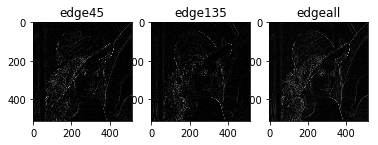

In [6]:
def roberts_edge(src):
    # 生成两个roberts算子
    R1=np.array([[1,0],[0,-1]],np.float32)
    R2=np.array([[0,1],[-1,0]],np.float32)
    IconR1=conv2d_same(src,R1,0,0,stride=1)
    IconR2=conv2d_same(src,R2,0,1,stride=1)
    ##print(IconR1)
    IconR1=np.abs(IconR1)
    IconR1=IconR1.astype(np.uint8)
    IconR2=np.abs(IconR2)
    IconR2=IconR2.astype(np.uint8)
    show_img(IconR1,"edge45",1,3,1)
    show_img(IconR2,"edge135",1,3,2)
    #cv2.imshow("edge45",IconR1)
    #cv2.imshow("edge135",IconR2)
    edge_all=np.sqrt(np.power(IconR1,2.0)+np.power(IconR2,2.0))
    edge_all=np.round(edge_all)
    edge_all[edge_all>255]=255
    edge_all=edge_all.astype(np.uint8)
    show_img(edge_all,"edgeall",1,3,3)
    #cv2.imshow("edgeall",edge_all)

roberts_edge(grayImage)
#print(grayImage)

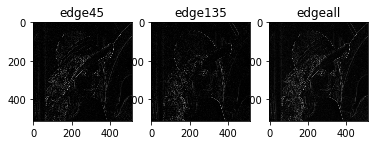

In [7]:
from scipy import signal
def roberts_with_conv2d_api(src):
    R1=np.array([[1,0],[0,-1]],np.float32)
    R2=np.array([[0,1],[-1,0]],np.float32)
    IconR1=signal.convolve2d(src,R1,mode='full',boundary='fill',fillvalue=0)
    IconR2=signal.convolve2d(src,R2,mode='full',boundary='fill',fillvalue=0)
    ##print(IconR1)
    IconR1=np.abs(IconR1)
    IconR1=IconR1.astype(np.uint8)
    IconR2=np.abs(IconR2)
    IconR2=IconR2.astype(np.uint8)
    show_img(IconR1,"edge45",1,3,1)
    show_img(IconR2,"edge135",1,3,2)
    #cv2.imshow("edge45",IconR1)
    #cv2.imshow("edge135",IconR2)
    edge_all=np.sqrt(np.power(IconR1,2.0)+np.power(IconR2,2.0))
    edge_all=np.round(edge_all)
    edge_all[edge_all>255]=255
    edge_all=edge_all.astype(np.uint8)
    show_img(edge_all,"edgeall",1,3,3)
    #cv2.imshow("edgeall",edge_all)
    

roberts_with_conv2d_api(grayImage)

#### prewitt算子

可分离卷积核.
![prewitt算子](https://gss2.bdstatic.com/-fo3dSag_xI4khGkpoWK1HF6hhy/baike/c0%3Dbaike72%2C5%2C5%2C72%2C24/sign=cb3bb6b043166d222c7a1dc6274a6292/ca1349540923dd54c88e9613d109b3de9d8248cf.jpg)

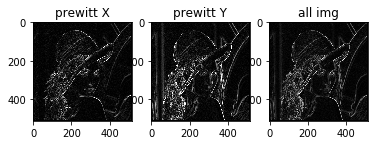

In [8]:
def prewitt(src):
    # 1. 垂直方向平滑,水平方向差分
    ones_y=np.array([[1],[1],[1]],np.float32)
    #ones_y=ones_y/np.sum(ones_y)
    #print(src)
    src_smth_y=conv1d_same(src,ones_y,1,0,stride=1)
    diff_x=np.array([[1,0,-1]],np.float32)
    #diff_x=diff_x/np.sum(diff_x)
    src_diff_x=conv1d_same(src_smth_y,diff_x,0,1,stride=1)
    src_diff_x=np.abs(src_diff_x)
    src_diff_x[src_diff_x>255]=255
    src_diff_x=src_diff_x.astype(np.uint8)
    #print(src_diff_x)
    show_img(src_diff_x,"prewitt X",1,3,1)

    # 2. 水平方向平滑,垂直方向差分
    ones_x=np.array([[1,1,1]],np.float32)
    src_smth_x=conv1d_same(src,ones_x,0,1,stride=1)
    diff_y=np.array([[1],[0],[-1]],np.float32)
    src_diff_y=conv1d_same(src_smth_x,diff_y,1,0,stride=1)
    src_diff_y=np.abs(src_diff_y)
    src_diff_y[src_diff_y>255]=255
    src_diff_y=src_diff_y.astype(np.uint8)
    show_img(src_diff_y,"prewitt Y",1,3,2)
    
    # 3. sqrt
    
    all_img=0.5*src_diff_x+0.5*src_diff_y
    all_img[all_img>255]=255
    show_img(all_img,"all img",1,3,3)
    
prewitt(grayImage)

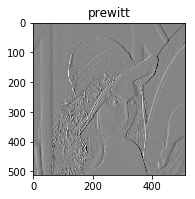

In [9]:
def prewitt_conv_api(src):
    ones_y=np.array([[1],[1],[1]],np.float32)
    src_smth_y=signal.convolve2d(src,ones_y,mode='same',boundary='symm')
    diff_x=np.array([[1,0,-1]],np.float32)
    src_diff_x=signal.convolve2d(src_smth_y,diff_x,mode='same',boundary='symm')
    show_img(src_diff_x,"prewitt",1,2,1)

prewitt_conv_api(grayImage)

#### sobel 算子

在坐标轴方向采用高斯平滑.

In [17]:
def pascalSmooth(n): 
    pascalSmooth=np.zeros([1,n],np.float32)
    for i in range(n):
        pascalSmooth[0][i]=math.factorial(n-1)/(math.factorial(i)*math.factorial(n-1-i)) # 利用二项式展开计算系数
    return pascalSmooth
pascalSmooth(4)

array([[1., 3., 3., 1.]], dtype=float32)

In [20]:
def pascalDiff(n):
    if n<=0:
        print("n should bigger than 0")
        return
    pascalDiff=np.zeros([1,n],np.float32)
    pascal_prev=pascalSmooth(n-1)
    for i in range(n):
        if i==0:
            pascalDiff[0][i]=pascal_prev[0][i]
        elif i==n-1:
            pascalDiff[0][i]=-pascal_prev[0][i-1] # 在n-1基础上左右扩展成0,然后在做差的时候的值是可以定下来的.
        else:
            pascalDiff[0][i]=pascal_prev[0][i]-pascal_prev[0][i-1] # 在n-1的分布上,由后项减前项
    return pascalDiff

A=pascalDiff(4)
#print(A.shape)
#print(A)

(1, 4)
[[ 1.  1. -1. -1.]]


In [25]:
#得到一个sobel kerne.实际上在使用sobel时这步是不需要的.因为我们这步可以实现分离的kernel相乘.
def getSobelKernel(n):
    pascalSmoothKernel=pascalSmooth(n)
    pascalDiffKernel=pascalDiff(n)
    cx=cy=int(n/2)
    sobelKernel_x=conv2d_same(pascalSmoothKernel.transpose(),pascalDiffKernel,cx,cy,stride=1)
    sobelKernel_y=conv2d_same(pascalSmoothKernel,pascalDiffKernel,cx,cy,stride=1)
    return (sobelKernel_x,sobelKernel_y)

getSobelKernel(4)

(array([[1.],
        [3.],
        [3.],
        [1.]], dtype=float32), array([[1., 3., 3., 1.]], dtype=float32))

(4, 1)
(1, 4)


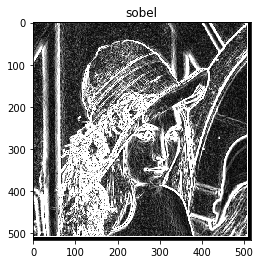

In [38]:
def sobel(src,n):
    pascal_smth=pascalSmooth(n)
    pascal_diff=pascalDiff(n)
    print(pascal_smth.transpose().shape)
    print(pascal_smth.shape)
    # 垂直方向平滑,水平上差分
    src_smth_y=conv1d_same(src,pascal_smth.transpose(),int(n/2),0,stride=1)
    src_diff_x=conv1d_same(src_smth_y,pascal_diff,0,int(n/2),stride=1)
    # 水平上平滑,垂直上差分
    src_smth_x=conv1d_same(src,pascal_smth,0,int(n/2),stride=1)
    src_diff_y=conv1d_same(src_smth_x,pascal_diff.transpose(),int(n/2),0,stride=1)
    src_all=np.sqrt(np.power(src_diff_x,2.0)+np.power(src_diff_y,2.0))
    src_all[src_all>255]=255
    src_all=src_all.astype(np.uint8)
    #show_img(src_all,"sobel",1,1,1)
    return src_all

src_all=sobel(grayImage,4)
show_img(src_all,"sobel with 4",1,1,1)

(5, 1)
(1, 5)


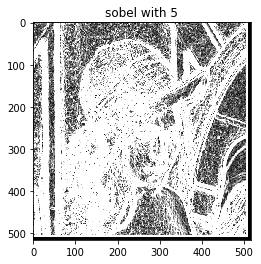

In [39]:
src_all=sobel(grayImage,5)
show_img(src_all,"sobel with 5",1,1,1)

(2, 1)
(1, 2)
(3, 1)
(1, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(4, 1)
(1, 4)


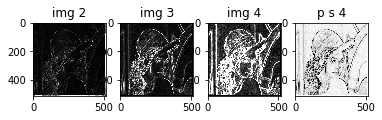

In [43]:
for n in range(2,5):
    sobel_img_=sobel(grayImage,n)
    show_img(sobel_img_,"img %s"%n,2,4,n-1)
    sobel_img_anticolor=sobel_img_3.astype(np.float32)
    sobel_img_anticolor=255-sobel_img_anticolor
    sobel_img_anticolor=sobel_img_anticolor.astype(np.uint8)
    show_img(sobel_img_anticolor,"p s %s"%n,2,4,n)